# Calculate near surface RH% using ERA-interim fields

* 2-m dew point
* 2-m temperature
* surface pressure

Once the yearly RH files are made, merge these data into a single file and put into the era merged time directory, then, regrid that file and place in the common grid file, such that this newly created variable has the same handling as variables processed by Python/format_raw_era_data.py

NOTE: RH was calculated from raw, native (0.75 x 0.75 deg grid) era-interim nc data. These data live in a different project directory (metSpreadData).   

Link to documentations and instructions on how to calculate near surface relative humidity using ecmwf era-interim:
https://www.ecmwf.int/en/faq/do-era-datasets-contain-parameters-near-surface-humidity

\begin{align}
RH=100\frac{es(T_{d})}{es(T)}
\end{align}

### Saturation Specific Humidity

Saturation specific humidity is expressed as a function of saturation water vapor pressure as:

\begin{align}
q_{sat} & = \frac{e_{sat}(T)\frac{R_{dry}}{R_{vapor}}}{p-(1-\frac{R_{dry}}{R_{vapor}})e_{sat}(T)}
\end{align}

where the saturation water vopor pressure ($e_{sat}$) is expressed with the Teten's formula:
\begin{align}
e_{sat}(T) & = a_{1}exp(a_{3}\frac{T - T_{0}}{T-a_{4}})\\
\\
a_{1} & = 611.21Pa \\
a_{3} & = 17.502 \\
a_{4} & = 32.19 \\
T_{0} & = 273.16
\end{align}

In [1]:
import numpy as np

def calculat_svp(T, P):
    """Calculates and returns saturation vapor pressure (svp)"""
    # constants for saturation over water 
    a1 = 611.21 # Pa
    a3 = 17.502
    a4 = 32.19 # K
    To = 273.16 # K 
    R_dry = 287. # J/kg/K gas constant of dry air
    R_vap = 461. # J/kg/K gas constant for water vapor 

    e_sat = a1 * np.exp( a3 * (T-To)/(T-a4) )

    # Saturation specific humidity (eqn 7.4)
    top = e_sat * R_dry / R_vap 
    bottom = P - (1. - R_dry / R_vap) * e_sat  
    q_sat = top / bottom
    
    return q_sat 

### Create 3D RH arrays

In [2]:
from netCDF4 import Dataset
import os
from matplotlib import pylab as plt
dataDir = os.path.join("..","..","metSpreadData","ERA-Interim")

def get_nc(var, year): 
    """
    Loads an era-interim netcdf file. Very simple. 
    """
    loadFile = os.path.join(dataDir, var + "_" + str(year) + ".nc")
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    t = nc.variables["time"][:]
    lon = nc.variables["longitude"][:]
    lat = nc.variables["latitude"][:]
    nc.close()
    return vals, t, lon, lat


def write_RH_nc(RH, t, x, y, year, dataDir):
    """
    Writes a relative humidity netcdf file. 
    """
    
    outputFile = os.path.join(dataDir, "RH_" + str(year) + ".nc")

    ncFile = Dataset(outputFile, 'w', format='NETCDF4')
    ncFile.description = 'Relative Humidity (saturation pressure relative to water, Tetons eq.)'
    ncFile.location = 'Global'
    ncFile.createDimension('time',  len(t) )
    ncFile.createDimension('latitude', len(y) )
    ncFile.createDimension('longitude', len(x) )

    VAR_ = ncFile.createVariable("RH", 'f4',('time', 'latitude','longitude'))
    VAR_.long_name = "Relative Humidity"
    VAR_.units = "%"

    # Create time variable
    time_ = ncFile.createVariable('time', 'i4', ('time',))
    time_.units = "hours since 1900-01-01 00:00:0.0"
    time_.calendar = "gregorian"
    
    # create lat variable
    latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
    latitude_.units = 'degrees_north'

    # create longitude variable
    longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
    longitude_.units = 'degrees_east'

    # Write the actual data to these dimensions
    VAR_[:]       = RH
    time_[:]      = t
    latitude_[:]  = y
    longitude_[:] = x

    ncFile.close()

Generate the RH yearly files!

In [3]:
years = range(1983, 2017+1)
for year in years :
    print("Making RH file for %i " % year)
    # Get the grids needed to calculate specific humidity
    t2m,t,x,y = get_nc("t2m", year) # 2 meter temperature
    d2m,t,x,y = get_nc("d2m", year) # 2 meter dew point
    sp,t,x,y  = get_nc("sp", year)  # Surface pressure 

    RH = calculat_svp(d2m, sp) / calculat_svp(t2m, sp) * 100.
    write_RH_nc(RH, t, x, y, year, dataDir)

Making RH file for 1983 
Making RH file for 1984 
Making RH file for 1985 
Making RH file for 1986 
Making RH file for 1987 
Making RH file for 1988 
Making RH file for 1989 
Making RH file for 1990 
Making RH file for 1991 
Making RH file for 1992 
Making RH file for 1993 
Making RH file for 1994 
Making RH file for 1995 
Making RH file for 1996 
Making RH file for 1997 
Making RH file for 1998 
Making RH file for 1999 
Making RH file for 2000 
Making RH file for 2001 
Making RH file for 2002 
Making RH file for 2003 
Making RH file for 2004 
Making RH file for 2005 
Making RH file for 2006 
Making RH file for 2007 
Making RH file for 2008 
Making RH file for 2009 
Making RH file for 2010 
Making RH file for 2011 
Making RH file for 2012 
Making RH file for 2013 
Making RH file for 2014 
Making RH file for 2015 
Making RH file for 2016 
Making RH file for 2017 


Show the last month for the last year output as an example of what these values and output look like. 
Make sure the dry places in the world have lower RH values. 

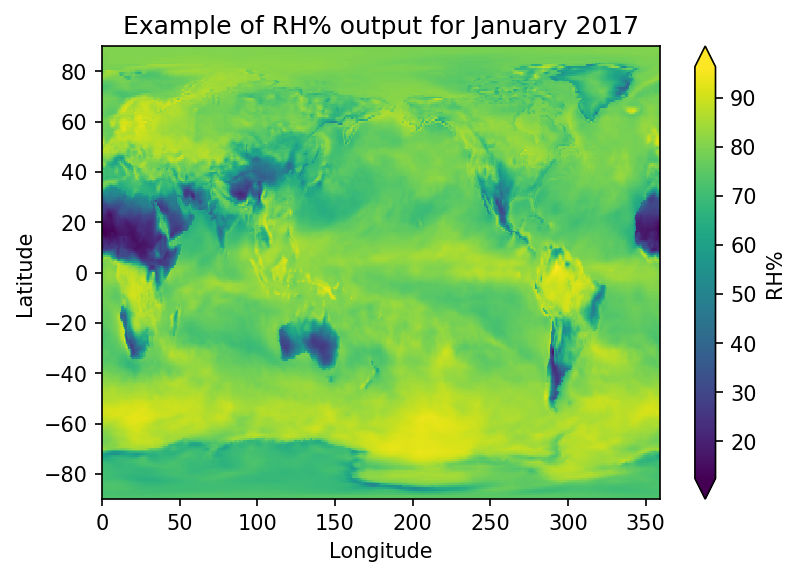

In [9]:
plt.figure(dpi=150)
plt.pcolor(x,y,RH[0,:,:])
plt.title("Example of RH% output for January 2017")
plt.colorbar(extend="both", label="RH%")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Merge yearly files and regrid 
- TODO: the code below is not working in a notebook, something strange with the call to Cdo()
- These commands were issued at the command line using cdo on 11/24/2018. 